## import Libraries

In [1]:
import numpy as np
from numpy import vstack
from numpy import argmax
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch 
import torchvision 
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torchvision import datasets
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import Adam
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from tqdm import tqdm 

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
train_data = datasets.FashionMNIST(
            root = 'data' , 
            train = True,
            download = True,
            transform = ToTensor())

test_data = datasets.FashionMNIST(
            root = 'data' ,
            train = False,
            download=True,
            transform = ToTensor())

In [4]:
loaders = {
      'train' : torch.utils.data.DataLoader(train_data , 
                                           batch_size=32,
                                           shuffle=True) ,
    
     'test' : torch.utils.data.DataLoader(test_data,
                                          batch_size=32,
                                         shuffle=False)
}

In [5]:
len(train_data)

60000

In [6]:
len(test_data)

10000

In [7]:
## Build Model 
## Convolutional Neural Network model

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN , self).__init__()
        ## Conv1D
        self.Conv1 = nn.Conv2d(in_channels=1 , out_channels=16, kernel_size=(3,3), stride=1 , padding=1)
        self.act1 = nn.ReLU()
        ## MaxPooling 1
        self.Max1 = nn.MaxPool2d(2)
        
        ## Convolution 2d
        self.Conv2 = nn.Conv2d(in_channels=16, out_channels=32 , kernel_size=(3,3) , stride=1 , padding=1)
        self.act2 = nn.ReLU()
        ## MaxPooling 2d
        self.max2 = nn.MaxPool2d(2)
       
        self.dropout = nn.Dropout(p=0.5)
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(1568, 10)
        self.softmax = nn.Softmax(dim=1)
    def forward(self , x):
            x = self.Conv1(x)
            x = self.act1(x)
            x = self.Max1(x)
            
            ## Convolution 2d
            x = self.Conv2(x)
            x = self.act2(x)
            x = self.max2(x)
            x = self.dropout(x)
            x = x.view(x.size(0), -1)
            x = self.fc1(x)
            x = self.softmax(x)
            return  x

In [9]:
model = CNN().to(device)

In [10]:
from torchsummary import summary

In [11]:
summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 28, 28]          160
├─ReLU: 1-2                              [-1, 16, 28, 28]          --
├─MaxPool2d: 1-3                         [-1, 16, 14, 14]          --
├─Conv2d: 1-4                            [-1, 32, 14, 14]          4,640
├─ReLU: 1-5                              [-1, 32, 14, 14]          --
├─MaxPool2d: 1-6                         [-1, 32, 7, 7]            --
├─Dropout: 1-7                           [-1, 32, 7, 7]            --
├─Linear: 1-8                            [-1, 10]                  15,690
├─Softmax: 1-9                           [-1, 10]                  --
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
Total mult-adds (M): 1.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.08
Estimated Total Size (MB): 0.22


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 28, 28]          160
├─ReLU: 1-2                              [-1, 16, 28, 28]          --
├─MaxPool2d: 1-3                         [-1, 16, 14, 14]          --
├─Conv2d: 1-4                            [-1, 32, 14, 14]          4,640
├─ReLU: 1-5                              [-1, 32, 14, 14]          --
├─MaxPool2d: 1-6                         [-1, 32, 7, 7]            --
├─Dropout: 1-7                           [-1, 32, 7, 7]            --
├─Linear: 1-8                            [-1, 10]                  15,690
├─Softmax: 1-9                           [-1, 10]                  --
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
Total mult-adds (M): 1.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.08
Estimated Total Size (MB): 0.22

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [13]:
#Train the model
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0.0
    model.train()
    for inputs,labels in tqdm(loaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.double() / len(train_data)

    print('{} loss: {:.4f}, acc: {:.4f}'.format('Train',
                                                epoch_loss,
                                                epoch_acc))


    running_loss = 0.0
    running_corrects = 0
    model.eval()
    for inputs, labels in tqdm(loaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs,1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_data)
    epoch_acc = running_corrects.double() / len(test_data)

    print('{} loss: {:.4f}, acc: {:.4f}'.format('Test',
                                                epoch_loss,
                                                epoch_acc))
        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:13<00:00, 141.09it/s]


Train loss: 1.7071, acc: 0.7593


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 174.07it/s]


Test loss: 1.6575, acc: 0.8048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 156.27it/s]


Train loss: 1.6570, acc: 0.8051


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 214.14it/s]


Test loss: 1.6421, acc: 0.8200


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 146.48it/s]


Train loss: 1.6475, acc: 0.8140


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 177.01it/s]


Test loss: 1.6290, acc: 0.8317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:14<00:00, 125.95it/s]


Train loss: 1.6162, acc: 0.8457


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 195.36it/s]


Test loss: 1.5989, acc: 0.8620


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:14<00:00, 133.43it/s]


Train loss: 1.6026, acc: 0.8591


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 187.41it/s]


Test loss: 1.5953, acc: 0.8656


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 148.88it/s]


Train loss: 1.5977, acc: 0.8646


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 176.04it/s]


Test loss: 1.5869, acc: 0.8744


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:14<00:00, 133.39it/s]


Train loss: 1.5930, acc: 0.8688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 206.80it/s]


Test loss: 1.5857, acc: 0.8762


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:14<00:00, 128.59it/s]


Train loss: 1.5881, acc: 0.8730


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 174.28it/s]


Test loss: 1.5813, acc: 0.8802


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:13<00:00, 136.34it/s]


Train loss: 1.5845, acc: 0.8770


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 193.30it/s]


Test loss: 1.5855, acc: 0.8762


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 148.18it/s]


Train loss: 1.5810, acc: 0.8806


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 219.92it/s]

Test loss: 1.5774, acc: 0.8845


In [61]:
inputs.shape

torch.Size([16, 1, 28, 28])

In [15]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [18]:
import cv2

In [23]:
test_1 = test_data.data[0]
test_2 = test_data.data[89]

In [24]:
import matplotlib.pyplot as plt

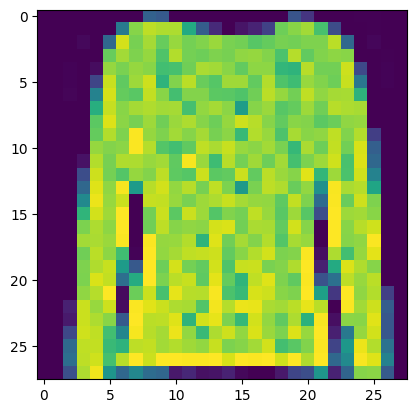

In [25]:
plt.imshow(test_2)

In [28]:
cv2.imwrite('test_1.jpg', test_1.numpy())
cv2.imwrite('test_2.jpg', test_2.numpy())

True

In [47]:
test_1

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [53]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [99]:
import json

In [102]:
with open('classes.json','w') as f:
    f.write(json.dumps(classes))

In [106]:
with open('classes.json','r') as f:
    classes = json.load(f)

In [108]:
classes

{'0': 'T-shirt/top',
 '1': 'Trouser',
 '2': 'Pullover',
 '3': 'Dress',
 '4': 'Coat',
 '5': 'Sandal',
 '6': 'Shirt',
 '7': 'Sneaker',
 '8': 'Bag',
 '9': 'Ankle boot'}

In [111]:
classes_2 = dict(zip(range(10),train_data.classes))

In [112]:
classes_2

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [116]:
classes_3 = train_data.classes
classes_3

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [103]:
from PIL import Image
import numpy as np
import json

In [30]:
model = model.eval()

In [87]:
img = Image.open('test_2.jpg')

In [88]:
input_img = np.asarray(img)

In [89]:
input_img = torch.tensor(input_img.reshape(-1,1,28,28), dtype=torch.float32, device=device)

In [90]:
input_img.shape

torch.Size([1, 1, 28, 28])

In [91]:
output = model(input_img).detach().cpu().numpy()

In [92]:
result = output.argmax()

In [117]:
print(" The class that the image belongs to is: ", classes_2[result])

 The class that the image belongs to is:  Pullover


In [119]:
torch.save(model.state_dict(), 'Fashion_Mnist.pth')